# VERIFICATION
In this notebook, we will validate the behavior of all functions to ensure they work as expected. We will also verify what can be simplified or neglected during the dimensioning process (handled in a separate notebook).

In [250]:
# 3rd Party Libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from IPython.display import display, Math

# Internal Libraries
import functions as f
import nuclei_func as nf
from functions import Material_Proprieties, ThermoHydraulicSpecs, GeometryData, DimensioningData, Temperature_Map

## Input Data

All material proprietes (Fuel, Helium, Cladding and Coolant) are saved in a custom defined class to avoid repeatedly passing many parameters to functions, reducing complexity and improving code readability and maintainability.

In [251]:
# Material: Cladding
# 15-15, Ti stabilized, cold worked stainless steel
Cladding_Proprieties = Material_Proprieties(
    Elements=["Cr", "Ni", "Mo", "Mn", "Si", "Ti", "C", "B [ppm]"],
    Qualities=[15, 15, 1.5, 1.5, 0.9, 0.4, 0.09, 60],
    Density=lambda eth: 7900 * (1 + eth)**-3,  # kg/m^3
    Thermal_Conductivity=lambda t: 13.95 + 0.01163 * t,  # W/m K
    Emissivity = 0.32, # -
    Thermal_Expansion_Coeff=lambda t: -3.101e-4 + 1.545e-5 * t + 2.75e-9 * t**2,  # 1/°C
    Specific_Heat=500,  # Approximate value in J/kg K for steel
    Melting_Temperature=1673,  # K
    
    Youngs_Modulus=lambda t: 202.7 - 0.08167 * t,  # GPa
    Poissons_Ratio=lambda t: 0.277 + 6e-5 * t,  # Dimensionless
    Yield_Stress=lambda t: 555.5 - 0.25 * t if t < 600 else (405.5 - 0.775 * (t - 600) if t < 1000 else 345.5 - 0.25 * t),  # MPa
    Ultimate_Tensile_Strength=lambda t: 700 - 0.3125 * t if t < 600 else (512.5 - 0.969 * (t - 600) if t < 1000 else 437.5 - 0.3125 * t),  # MPa
)

# Material: Fuel
# Homogeneous MOX fuel

# Qualities have to be converted from weight to molar (won't change in hot condition):
mol_qual = nf.w2mol([0.711, 0.29], [235 + 2*16, 239 + 2*16])  # UO2, PuO2

Fuel_Proprieties = Material_Proprieties(
    Elements=["U-235", "U-238", "O-16", "Pu"],
    Qualities=[mol_qual[0] * (1 - mol_qual[1]), (1 - mol_qual[0]) * (1 - mol_qual[1]), 2, mol_qual[1]], # Molar fractions
    Theoretical_Density=11.31, # g/cm^3
    Percent_of_Theoretical_Density = 94.5, # %
    Molar_Mass=[235.0439299, 238.05078826, 15.99491461956, 244.064204],  # g/mol
    Thermal_Conductivity=lambda k_inf, beta: 1.755 + (k_inf - 1.755) * math.exp(-beta),  # W/m K
    Emissivity = 0.79, # -
    Thermal_Expansion_Coeff=1.2e-5,  # 1/°C
    Specific_Heat=270,  # Approximate value in J/kg K for MOX fuel
    Melting_Temperature=lambda pu, x, beta: 2964.92 + ((3147 - 364.85 * pu - 1014.15 * x) - 2964.92) * math.exp(-beta/41.01),  # K
    Oxigen_to_metal_ratio = 1.957, # -
    Grain_diameter = 10 * 1e-6,  # m
    Youngs_Modulus=lambda t, p: (22.43 * 10**4 - 31.19 * t) * (1 - 2.6 * p),  # MPa
    Poissons_Ratio=0.32,  # Dimensionless
)

# Material: Coolant (Sodium)
Coolant_Proprieties = Material_Proprieties(
    Elements=["Na"],
    Qualities=[1],
    Density=lambda t: 954.1579 + ((t-273) * 9/5 +32) *( ((t-273) * 9/5 +32) * ((((t-273) * 9/5 +32) * 0.9667e-9 - 0.46e-5)) - 0.1273534),  # kg/m^3 (t * 9/5 +32) is the convertion from C to K to F
    Viscosity=lambda t: (math.exp(813.9 / t -2.530 ))/1000,  # Pa s
    Thermal_Conductivity=lambda t: 110 - 0.0648 * t + 1.16e-5 * t**2,  # W/m K
    Specific_Heat=lambda t: 1608 - 0.7481 * t + 3.929e-4 * t**2,  # J/kg K
    
    Melting_Temperature=98,  # °C
    Boiling_Temperature=882,  # °C
    Nusselt_Number=lambda pe: 7 + 0.025 * pe**0.8
)

# Material: Helium (Filling Gas)
Helium_Proprieties = Material_Proprieties(
    Elements=["He"],
    Qualities=[1],
    Density=0.1786,  # kg/m^3 at STP
    Thermal_Conductivity=lambda t: 15.8e-4 * t**0.79,  # W/m K
    Specific_Heat=5193,  # J/kg K at constant pressure
    Thermal_Expansion_Coeff=3.66e-3  # Approximate value for helium in 1/°C
)


Other data is saved as common variables

In [252]:
Geometrical_Data = GeometryData(
    fuel_outer_diameter=5.42 * 1e-3,  # m - GIVEN
    fuel_inner_diameter=0.00 * 1e-3,  # m
    cladding_outer_diameter=6.55 * 1e-3,  # m - GIVEN
    thickness_cladding=100 * 1e-6, # m
    pin_pitch=8.275 * 1e-3,  # m
    h_values = np.linspace(0, 0.85, 10), # m
    fuel_pellet_height = 7e-3, # m
    fuel_roughness = 2e-6, # m
    cladding_roughness = 1e-6 # m
)

# Example of initializing Thermo-Hydraulic specifications
heights_of_slice_centre = [42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5] # mm
ThermoHydraulics = ThermoHydraulicSpecs(
    coolant_inlet_temp=395 + 273,  # K
    coolant_inlet_pressure=1e5,  # Pa
    coolant_mass_flow_rate=0.049,  # kg/s
    q_linear_avg = 38.7e3,  #W/m,
    uptime = 360 * 24 * 3600,  # s
    h_peak_factor = [h * 1e-3 for h in heights_of_slice_centre],  # m
    peak_factors = [0.572, 0.737, 0.868, 0.958, 1, 0.983, 0.912, 0.802, 0.658, 0.498],
    neutron_flux_peak = 6.1e15  # Neutron Flux (> 100 keV) (10^15 n cm^-2 s^-1) at Peak Power Node    
)

vars = DimensioningData(
    filling_gas_pressure = 1e5,  # Pa
    filling_gas_temperature = 20,  # °C
    temperature_map = ''
)

# Data for Axial Nodalization of the Fuel Pin



Verification parameters that will be needed for dimensioning

In [253]:
# Data for Indicative Design Limits
max_fuel_temp = 2600  # °C
max_cladding_temp = 650  # °C
max_plenum_pressure = 5  # MPa
max_cladding_plastic_strain = 0.5  # %
max_cladding_swelling = 3  # %
max_coolant_velocity = 8  # m/s

## Thermal - Hydraulics Analysis

In [254]:
Computing_Temperature = ThermoHydraulics.coolant_inlet_temp  # K
display(Math(r'T_{\text{Computing}} = %s \, \text{K}' % Computing_Temperature))

<IPython.core.display.Math object>

In [255]:
#Preliminary check of coolant properties

density = Coolant_Proprieties.Density(Computing_Temperature)
viscosity = Coolant_Proprieties.Viscosity(Computing_Temperature)
thermal_conductivity = Coolant_Proprieties.Thermal_Conductivity(Computing_Temperature)
c_p = Coolant_Proprieties.Specific_Heat(Computing_Temperature)

display(Math(r'\rho_{coolant} =' + f'{density:.2f}' + r'\text{ kg/m}^3' ))
display(Math(r'\mu_{coolant} =' + f'{viscosity*1000:.2f}' + r'\text{ mPa s}' ))
display(Math(r'k_{coolant} =' + f'{thermal_conductivity:.2f}' + r'\text{ W/m K}' ))
display(Math(r'c_p =' + f'{c_p:.2f}' + r'\text{ J/kg K}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [256]:
# Velocity and Passage Area Calculation
# To be modified with a proper evaluation

velocity, passage_area, d_h = f.hydraulic_flow(ThermoHydraulics, Geometrical_Data, Coolant_Proprieties, Computing_Temperature)

display(Math(r'v_{coolant} =' + f'{velocity:.2f}' + r'\text{ m/s}' ))
display(Math(r'A_{passage} =' + f'{passage_area*1e6:.2f}' + r'\text{ mm}^2' ))
display(Math(r'D_{hydr} =' + f'{d_h*1e3:.2f}' + r'\text{ mm}'))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [257]:
# Computing the Heat Transfer Coefficient between the Coolant and the cladding
htc_coolant, reynolds, prandtl, peclet, nusselt, d_h = f.heat_trans_coefficient(Geometrical_Data, ThermoHydraulics, Coolant_Proprieties, Computing_Temperature)
# Display the heat transfer coefficient
display(Math(r'\alpha_{cladding - coolant} =' + f'{htc_coolant*1e-3:.2f}' + r'\text{ kW/m}^2\text{K}'))
display(Math(r'Re =' + f'{reynolds:.2f}'))
display(Math(r'Pe =' + f'{peclet:.2f}' ))
display(Math(r'Pr =' + f'{prandtl:.4f}' ))
display(Math(r'D_{h} =' + f'{d_h*1e3:.2f}' + r'\text{ mm}' ))
display(Math(r'Nu =' + f'{nusselt:.2f}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Axial Power Profile

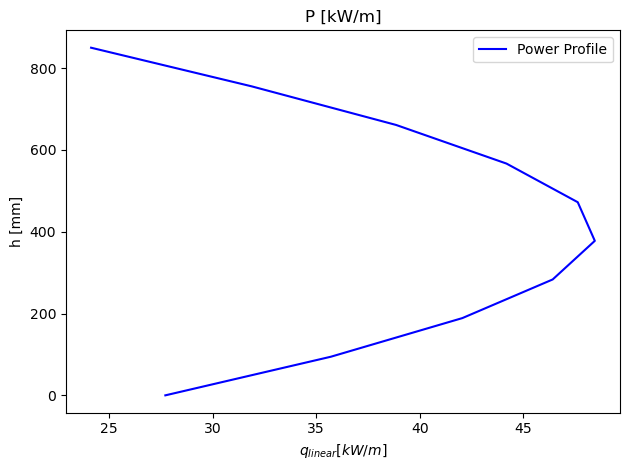

In [258]:
q_values = [f.power_profile(h, ThermoHydraulics) for h in Geometrical_Data.h_values]

# Create a figure with one subplot
fig, (power1) = plt.subplots(1)

# Plot the power profile
power1.plot(np.array(q_values)*1e-3, np.array(Geometrical_Data.h_values)*1e3, label='Power Profile', color='blue')

# Set title and axis labels
power1.set_title(r'P [kW/m]')
power1.set_xlabel(r'$q_{linear} [kW/m]$')
power1.set_ylabel(r'h [mm]')

# Add legend to the plot
power1.legend()

# Adjusts spacing between the plots
plt.tight_layout()

# Show the figure
plt.show()

### Radial temperature profile
Thermal resistances  
Fuel - Helium (gap) - Cladding - Coolant

In [259]:
R_coolant = f.thermal_resistance_coolant(Geometrical_Data, htc_coolant)
display(Math(r'R_{coolant} =' + f'{R_coolant:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [260]:
R_cladding = f.thermal_resistance_cladding(Geometrical_Data, Cladding_Proprieties, Computing_Temperature)
display(Math(r'R_{cladding} =' + f'{R_cladding:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [261]:
R_gap = f.thermal_resistance_gap(
    Geometrical_Data, Helium_Proprieties, Fuel_Proprieties, Cladding_Proprieties)

# Just to print a value
Temperature_Fuel_Out = Computing_Temperature # K
Temperature_Cladding_In = Computing_Temperature
Temperature_Gas = (Temperature_Fuel_Out + Temperature_Cladding_In) / 2
R_gap_eval = R_gap(Temperature_Gas, Temperature_Fuel_Out)
display(Math(r'R_{gap} =' + f'{R_gap_eval:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [262]:
Temperature_Fuel = Computing_Temperature
Burnup = 0

R_fuel = f.thermal_resistance_fuel(Burnup, Fuel_Proprieties) # Outputs a lambda function
R_fuel_eval = R_fuel(Temperature_Fuel) # Evaluate the lambda function for display
display(Math(r'R_{fuel} =' + f'{R_fuel_eval:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [263]:
class th_resistances:
    def __init__(self, R_fuel, R_gap, R_cladding, R_coolant):
        self.Fuel = R_fuel
        self.Gap = R_gap
        self.Cladding = R_cladding
        self.Coolant = R_coolant

Resistances = th_resistances(R_fuel, R_gap, R_cladding, R_coolant)

### Temperature Profile


3D plot computes all the points

In [264]:
# Pre-compute the temperature matrix using the plot function
r_coolant_infinity = Geometrical_Data.cladding_outer_diameter / 2 + Geometrical_Data.pin_pitch / np.sqrt(3)
r_coolant_cladding = Geometrical_Data.cladding_outer_diameter / 2
r_cladding_gap = Geometrical_Data.cladding_outer_diameter / 2 - Geometrical_Data.thickness_cladding
r_gap_fuel = Geometrical_Data.fuel_outer_diameter / 2
r_end = Geometrical_Data.fuel_inner_diameter / 2

r_coolant = np.linspace(r_coolant_infinity, r_coolant_cladding, 2)[0:-1]
r_cladding = np.linspace(r_coolant_cladding, r_cladding_gap, 2)[0:-1]
r_gap = np.linspace(r_cladding_gap, r_gap_fuel,5)[0:-1]
r_fuel = np.linspace(r_gap_fuel, r_end, 10)

r_plot = np.concatenate((r_coolant, r_cladding, r_gap, r_fuel))
# print(r_plot)
print(len(r_plot))
# r_plot = np.linspace(Geometrical_Data.cladding_outer_diameter/2 + 3e-3, 0, 100)

# 3D plot of the temperature profile
T_fuel_out = 1500 # K (Initial guess)
vars.T_map = f.temperature_profile_3D(r_plot, Resistances, Coolant_Proprieties, ThermoHydraulics, Geometrical_Data, T_fuel_out, Burnup)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=vars.T_map.T, x=vars.T_map.r*1e3, y=vars.T_map.h*1e3, colorscale='Viridis')])

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Radius (mm)',
        yaxis_title='Height (mm)',
        zaxis_title='Temperature (K)'
    ),
    title="3D Temperature Profile vs. Radius and Height (q_values)",
    autosize=False,
    width=800,
    height=800
)

# Show the plot
fig.show()
    

16


We can get the temperature value at any point

In [265]:
# Get temperature at a specific point (height and radius) using pre-computed data
height = 0e-3 # mm
radius = 8e-3 # mm
temperature_at_point = f.get_temperature_at_point(height, radius, vars.T_map)
print(f"Temperature at height {height*1e3} mm and radius {radius*1e3} mm: {temperature_at_point:.2f} K")

Temperature at height 0.0 mm and radius 8.0 mm: 688.81 K


We can plot the radial temperature profile

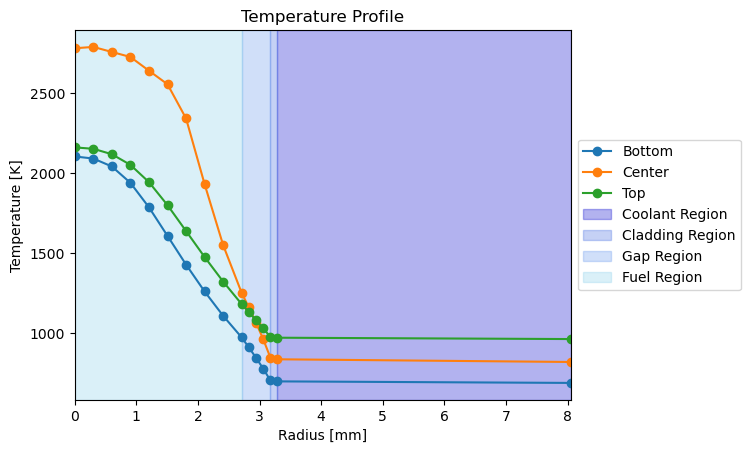

In [266]:
# 2D plot of the temperature profile
temp_plot_bottom = [f.get_temperature_at_point(0, r, vars.T_map) for r in r_plot]
temp_plot_center = [f.get_temperature_at_point(0.425, r, vars.T_map) for r in r_plot]
temp_plot_top = [f.get_temperature_at_point(0.850, r, vars.T_map) for r in r_plot]

# Create plot
plt.plot(r_plot * 1e3, temp_plot_bottom, label='Bottom', marker='o')
plt.plot(r_plot * 1e3, temp_plot_center, label='Center', marker='o')
plt.plot(r_plot * 1e3, temp_plot_top, label='Top', marker='o')

r_0 = Geometrical_Data.fuel_inner_diameter/2 * 1e3
r_1 = Geometrical_Data.fuel_outer_diameter/2 * 1e3
r_2 = Geometrical_Data.cladding_outer_diameter/2 * 1e3 - Geometrical_Data.thickness_cladding * 1e3
r_3 = Geometrical_Data.cladding_outer_diameter/2 * 1e3 
r_4 = r_plot[0]*1e3

# Add shading to different regions
colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB']
plt.axvspan(r_3, r_4, color=colors[1], alpha=0.3, label='Coolant Region')
plt.axvspan(r_2, r_3, color=colors[2], alpha=0.3, label='Cladding Region')
plt.axvspan(r_1, r_2, color=colors[3], alpha=0.3, label='Gap Region')
plt.axvspan(r_0, r_1, color=colors[4], alpha=0.3, label='Fuel Region')

# Set title and axis labels
plt.title('Temperature Profile')
plt.xlabel('Radius [mm]')
plt.xlim(r_0, r_4)
plt.ylabel('Temperature [K]')

# Add legend to the plot
plt.legend()

# Put the legend out of the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()

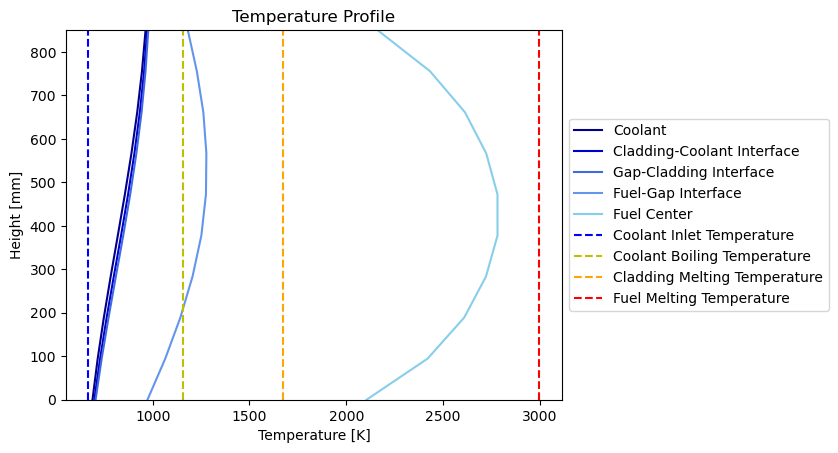

In [267]:
# 2D plot of the temperature profiles along the axial direction
r_to_plot = [vars.T_map.r[-1],
             Geometrical_Data.cladding_outer_diameter/2,
             Geometrical_Data.cladding_outer_diameter / 2 - Geometrical_Data.thickness_cladding,
             Geometrical_Data.fuel_outer_diameter/2,
             Geometrical_Data.fuel_inner_diameter/2]

labels = ['Coolant', 
          'Cladding-Coolant Interface', 
          'Gap-Cladding Interface', 
          'Fuel-Gap Interface', 
          'Fuel Center']

colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB']
h_vals = Geometrical_Data.h_values

to_plot = 5
for i in range(to_plot):
    temp_axial = [f.get_temperature_at_point(h, r_to_plot[i], vars.T_map) for h in h_vals]
    plt.plot(temp_axial, h_vals*1e3, label=labels[i], color=colors[i])

# Plot a line at the coolant inlet temperature
plt.axvline(x=ThermoHydraulics.coolant_inlet_temp, color='b', linestyle='--', label='Coolant Inlet Temperature')

# Plot a line at the coolant boling temperature
plt.axvline(x=Coolant_Proprieties.Boiling_Temperature + 273, color='y', linestyle='--', label='Coolant Boiling Temperature')

# Plot a line at the cladding melting temperature
plt.axvline(x=Cladding_Proprieties.Melting_Temperature, color='orange', linestyle='--', label='Cladding Melting Temperature')

# Plot a line at the fuel melting temperature
stechiometry = 2 - Fuel_Proprieties.Oxigen_to_metal_ratio
pu_weight = 0.29
plt.axvline(x=Fuel_Proprieties.Melting_Temperature(pu_weight,stechiometry,Burnup), color='r', linestyle='--', label='Fuel Melting Temperature')

# Set title and axis labels
plt.title('Temperature Profile')
plt.ylabel('Height [mm]')
plt.ylim(0, 850)
plt.xlabel('Temperature [K]')

# Put the legend outside the plot
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()

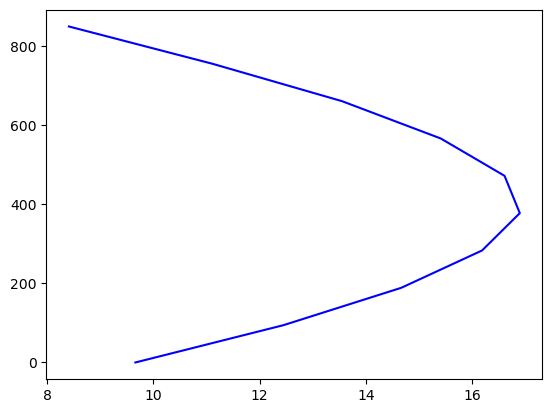

In [268]:
# plot the difference between the coolant profile and the cladding profile
temp_coolant = [-f.get_temperature_at_point(h, r_to_plot[0], vars.T_map) + f.get_temperature_at_point(h, r_to_plot[1], vars.T_map) for h in h_vals]

plt.plot(temp_coolant, h_vals*1e3, label='Coolant', color='blue')
plt.show()

## THERMAL EXPANSION

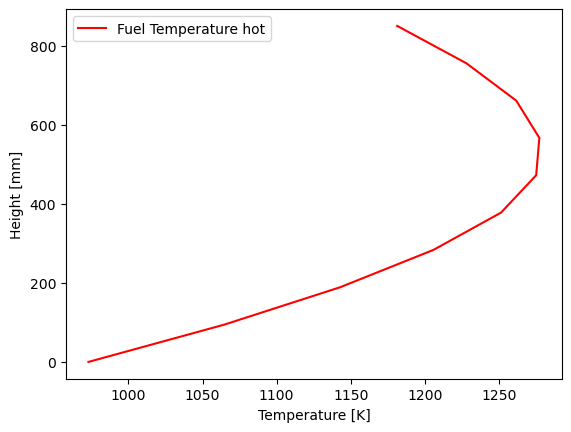

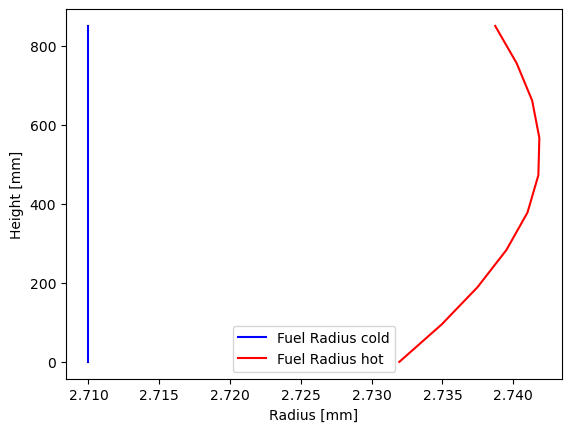

In [269]:
# Find the outer radius of the fuel in hot geometry

R_fuel_hot, R_init_fuel, T_hot_fuel = f.cold_to_hot_fuel(Fuel_Proprieties, Geometrical_Data, vars, h_vals)

# Plot axial temperature profile of fuel

plt.figure()
plt.plot(T_hot_fuel, h_vals * 1e3, label='Fuel Temperature hot', color='red')
plt.ylabel('Height [mm]')
plt.xlabel('Temperature [K]')
plt.legend()
plt.show()


# Plot axial profile of the thermal expansion with respect to the cold fuel radius

plt.figure()
plt.plot(np.array(R_init_fuel) * 1e3, h_vals * 1e3, label='Fuel Radius cold', color='blue')
plt.plot(np.array(R_fuel_hot) * 1e3, h_vals * 1e3, label='Fuel Radius hot', color='red')
plt.xlabel('Radius [mm]')
plt.ylabel('Height [mm]')
plt.legend()
plt.show()


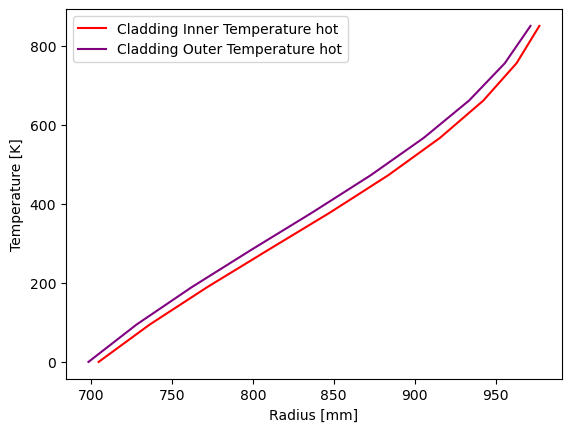

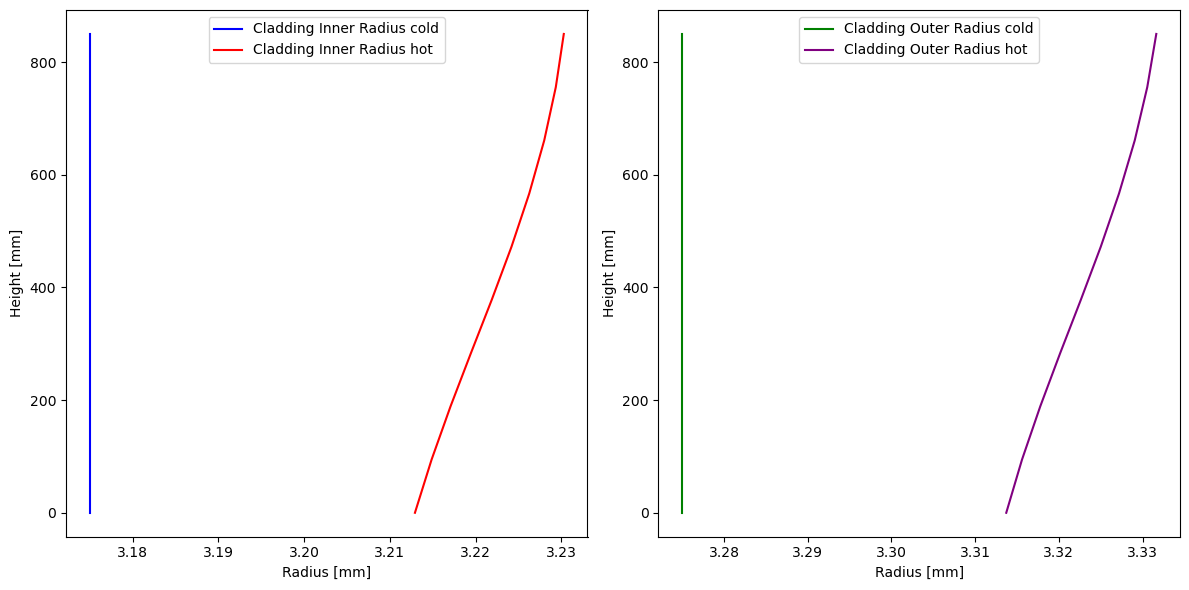

In [270]:
# Find the inner and outer radius of the cladding in hot geometry

R_clad_hot_in, R_init_clad_in, T_hot_clad_in = f.cold_to_hot_clad(Cladding_Proprieties, Geometrical_Data, vars, h_vals, flag = 'inner')
R_clad_hot_out, R_init_clad_out, T_hot_clad_out = f.cold_to_hot_clad(Cladding_Proprieties, Geometrical_Data, vars, h_vals, flag = 'outer')

# Plot axial temperature profile of cladding

plt.figure()
plt.plot(T_hot_clad_in, h_vals * 1e3, label='Cladding Inner Temperature hot', color='red')
plt.plot(T_hot_clad_out, h_vals * 1e3, label='Cladding Outer Temperature hot', color='purple')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()


# Plot axial profile of the thermal expansion with respect to the cold caldding radius

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the inner radius of the cladding
ax1.plot(np.array(R_init_clad_in) * 1e3, h_vals * 1e3, label='Cladding Inner Radius cold', color='blue')
ax1.plot(np.array(R_clad_hot_in) * 1e3, h_vals * 1e3, label='Cladding Inner Radius hot', color='red')
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('Height [mm]')
ax1.legend()

# Plot the outer radius of the cladding
ax2.plot(np.array(R_init_clad_out) * 1e3, h_vals * 1e3, label='Cladding Outer Radius cold', color='green')
ax2.plot(np.array(R_clad_hot_out) * 1e3, h_vals * 1e3, label='Cladding Outer Radius hot', color='purple')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('Height [mm]')
ax2.legend()

plt.tight_layout()
plt.show()


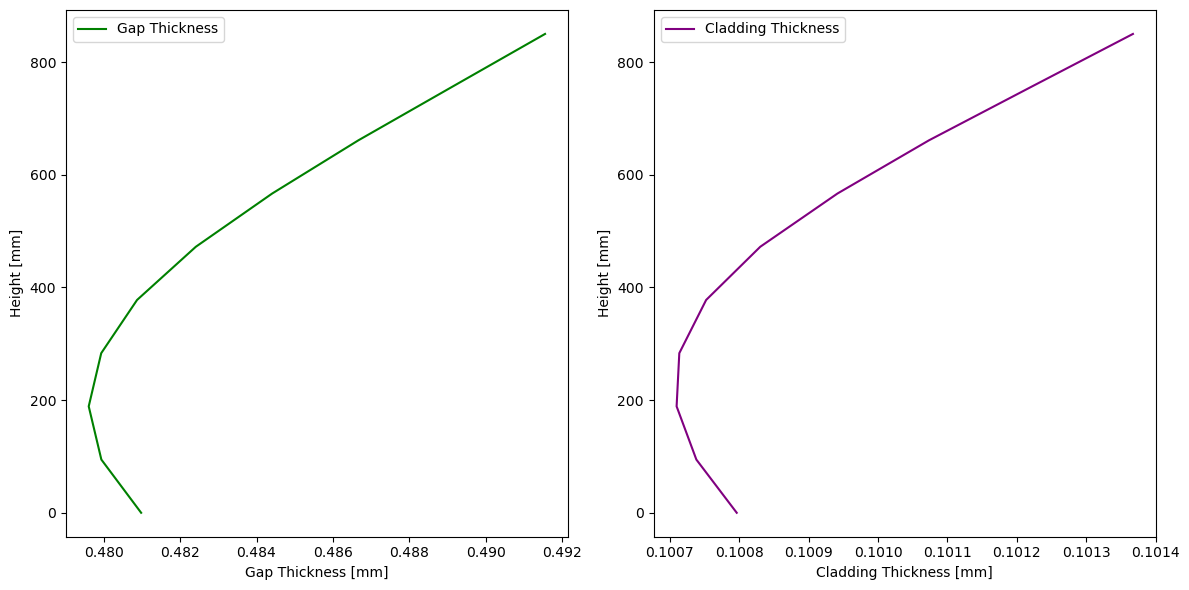

In [271]:
# Plot the gap thickness

gap_thickness = np.array(R_clad_hot_in)-np.array(R_fuel_hot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gap thickness
ax1.plot(gap_thickness * 1e3, h_vals * 1e3, label='Gap Thickness', color='green')
ax1.set_xlabel('Gap Thickness [mm]')
ax1.set_ylabel('Height [mm]')
ax1.legend()

# Plot the cladding thickness
clad_thickness = np.array(R_clad_hot_out) - np.array(R_clad_hot_in)
ax2.plot(clad_thickness * 1e3, h_vals * 1e3, label='Cladding Thickness', color='purple')
ax2.set_xlabel('Cladding Thickness [mm]')
ax2.set_ylabel('Height [mm]')
ax2.legend()

plt.tight_layout()
plt.show()


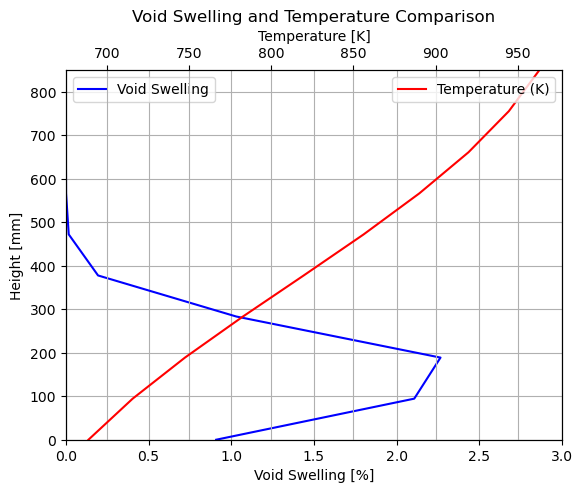

In [272]:
# Find the outer radius of the fuel in hot geometry
void_swell = f.void_swelling(vars.T_map, Geometrical_Data, ThermoHydraulics)
# Calculate void swelling and average temperature
void_swell = np.array(void_swell)
avg_temp = np.mean(vars.T_map.T[:, 0])
y_axis = vars.T_map.h[:, 0] * 1e3

# Create the main plot for Void Swelling
fig, ax1 = plt.subplots()

# Plot Void Swelling
ax1.plot(void_swell, y_axis, label='Void Swelling', color='blue')
ax1.set_xlabel('Void Swelling [%]')
ax1.set_ylabel('Height [mm]')
ax1.grid(True)
ax1.set_xlim(0, 3)

# Create a secondary x-axis sharing the same y-axis for Temperature
ax2 = ax1.twiny()
ax2.plot(vars.T_map.T[:, 0], y_axis, label=f'Temperature (K)', color='red')
ax2.set_xlabel('Temperature [K]')
ax2.grid(True)
# ax2.set_xlim(min(vars.T_map.T[:, 0]), max(vars.T_map.T[:, 0]))

# Add the legend and title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Void Swelling and Temperature Comparison')
plt.ylim(0, 850)
# plt.axvline((Cladding_Proprieties.Melting_Temperature) * 0.4, color='orange', linestyle='--', label='30% Melting Temperature')
# plt.axvline(Cladding_Proprieties.Melting_Temperature * 0.6, color='orange', linestyle='--', label='60% Melting Temperature')

# Show the plot
plt.show()


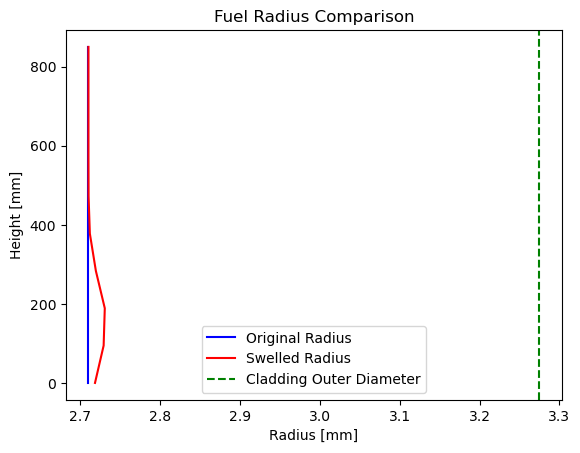

In [273]:
void_swell = f.void_swelling(vars.T_map, Geometrical_Data, ThermoHydraulics)
radius_before = Geometrical_Data.fuel_outer_diameter / 2
radius_swelled = [radius_before * (1 + 1/3*swell/100) for swell in void_swell]

# Plot comparison of the original and swelled fuel radius
plt.plot([radius_before*1e3] * 10, y_axis, label='Original Radius', color='blue')
plt.plot(np.array(radius_swelled) * 1e3, y_axis, label='Swelled Radius', color='red')
plt.axvline(Geometrical_Data.cladding_outer_diameter / 2 * 1e3, color='green', linestyle='--', label='Cladding Outer Diameter')
plt.xlabel('Radius [mm]')
plt.ylabel('Height [mm]')
plt.title('Fuel Radius Comparison')
plt.legend()


# Void Fromation and Fuel Restructuring

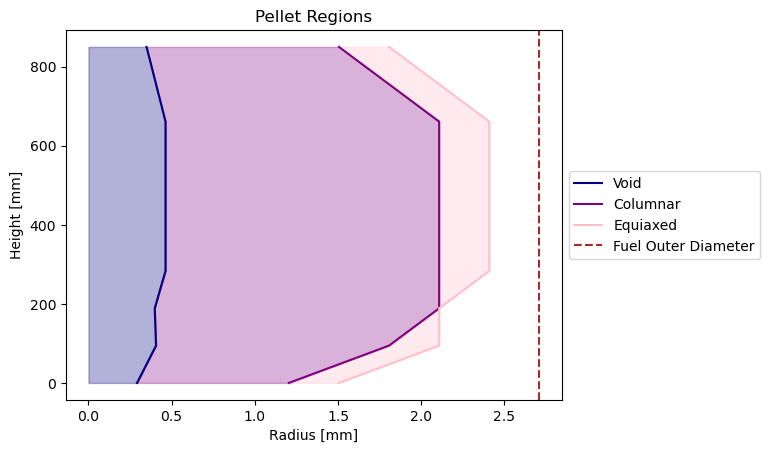

In [274]:
r_col = f.get_radius_at_temperature(1800, vars.T_map)
r_eq = f.get_radius_at_temperature(1600, vars.T_map)
r_void = f.get_R_void(Fuel_Proprieties, r_col, r_eq)


# plot the radius profile versus height
plt.plot(np.array(r_void)*1e3, np.array(vars.T_map.h[:,0])*1e3, color='navy', label='Void')
plt.plot(np.array(r_col)*1e3, np.array(vars.T_map.h[:,0])*1e3, color='purple', label='Columnar')
plt.plot(np.array(r_eq)*1e3, np.array(vars.T_map.h[:,0])*1e3, color='pink', label='Equiaxed')

plt.axvline(x=Geometrical_Data.fuel_outer_diameter/2 * 1e3, color='brown', linestyle='--', label='Fuel Outer Diameter')

plt.title('Pellet Regions')
plt.xlabel('Radius [mm]')
plt.ylabel('Height [mm]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.fill_betweenx(np.array(vars.T_map.h[:,0])*1e3, 0, np.array(r_void)*1e3, color='navy', alpha=0.3)
plt.fill_betweenx(np.array(vars.T_map.h[:,0])*1e3, np.array(r_void)*1e3, np.array(r_col)*1e3, color='purple', alpha=0.3)
plt.fill_betweenx(np.array(vars.T_map.h[:,0])*1e3, np.array(r_col)*1e3, np.array(r_eq)*1e3, color='pink', alpha=0.3)

plt.show()

# Fission Gas Behaviour
We start by evaluating the general expression for the fission product concentration as a function of Burnup

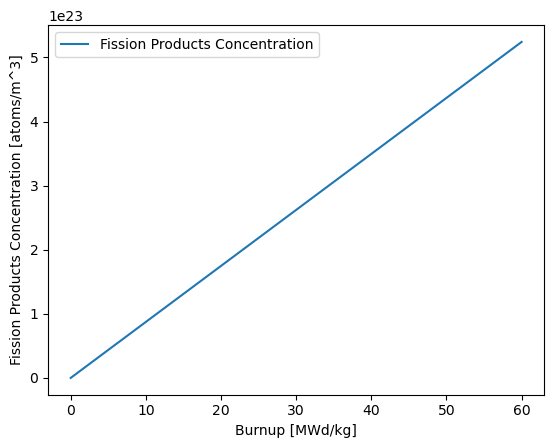

In [275]:
# General expression for fission products' concentration, change parameters as preferred

FP_yield = 0.3 # fission products yield for Xe + Kr
Energy_per_fission = 203.89 * 1.6e-13 # J/fission


# function: Burnup in MWd/kg and Energy per fission in MWd/fission!
FP_concentration = lambda Burnup: (FP_yield * Fuel_Proprieties.Density / (Energy_per_fission * 2.7e-10/24)) * Burnup

# Plot the fission products' concentration
burnup_vals = np.linspace(0, 60, 100)
FP_vals = FP_concentration(burnup_vals)

plt.plot(burnup_vals, FP_vals, label='Fission Products Concentration')
plt.xlabel('Burnup [MWd/kg]')
plt.ylabel('Fission Products Concentration [atoms/m^3]')
plt.legend()
plt.show()



Now we work on the Rate theory equations

In [276]:
#### define the various parameters for the Rate theory equations, good after the INCUBATION TIME

# size of grain
a = 10e-6 # m

### compute the average fission rate in [fissions/m^3 s]

# fission cross sections (see file ""Useful Data.xlsx"")
sigma_235 = 1.047756375 # barn
sigma_238 = 0.55801001 # barn
sigma_pu = 1.689844625 # barn

molar_mass = nf.mixture(Fuel_Proprieties.Molar_Mass, Fuel_Proprieties.Qualities) # g/mol

macro_235 = nf.macro(sigma_235, Fuel_Proprieties.Density, molar_mass) # cm^-1
macro_238 = nf.macro(sigma_238, Fuel_Proprieties.Density, molar_mass) # cm^-1
macro_pu = nf.macro(sigma_pu, Fuel_Proprieties.Density, molar_mass) # cm^-1

fission_xs = nf.mixture([macro_235, macro_238, 0, macro_pu], Fuel_Proprieties.Qualities) # cm^-1
display('Parameters computed:')
display(Math(r'\Sigma_f =' + f'{fission_xs:.2e}' + r'\text{ cm}^{-1}'))

'Parameters computed:'

<IPython.core.display.Math object>

In [277]:
peak_to_average_ratio = max(q_values)/ThermoHydraulics.q_linear_avg
average_neutron_flux = ThermoHydraulics.neutron_flux_peak / peak_to_average_ratio
display(Math(r'\phi_{\text{avg}} =' + f'{average_neutron_flux:.2e}' + r'\text{ n/cm}^2\text{s}'))

<IPython.core.display.Math object>

In [278]:
avg_fission_rate = average_neutron_flux * fission_xs * 1e6 # [fissions/m^3 s]
display(Math(r'f_{\text{rate}} =' + f'{avg_fission_rate:.2e}' + r'\text{ fissions/m}^3\text{s}'))

<IPython.core.display.Math object>

In [279]:
# q_volume_avg = ThermoHydraulics.q_linear_avg / np.pi * Geometrical_Data.fuel_outer_diameter * Geometrical_Data.fuel_pellet_height
# avg_fission_rate = q_volume_avg / Energy_per_fission # obtaining [fissions/m^3 s], Energy per fission in J/fission (TO FIX)

### diffusivity evaluation [Matzke, 1980]
d_0 = 5e-8 # m^2/s
q = 40262 
diffusivity = lambda temperature: d_0 * np.exp(- q / temperature) # m^2/s

temperature_max_average_fuel = (f.get_temperature_at_point(0.425, Geometrical_Data.fuel_inner_diameter/2, vars.T_map) + 
                                f.get_temperature_at_point(0, Geometrical_Data.fuel_inner_diameter/2, vars.T_map) +
                                f.get_temperature_at_point(0.850, Geometrical_Data.fuel_inner_diameter/2, vars.T_map)) / 3

display(Math(r'T_{\text{max-avg}} =' + f'{temperature_max_average_fuel:.2f}' + r'\text{ K}'))

<IPython.core.display.Math object>

In [280]:
diffusivity_coeff = diffusivity(temperature_max_average_fuel) # m^2/s
display(Math(r'D_{eff} =' + f'{diffusivity_coeff:.2e}' + r'\text{ m}^2/\text{s}'))

<IPython.core.display.Math object>

In [281]:
### set the problem with Rate theory equations
r = sp.symbols('r')
t = sp.symbols('t', positive = True)

symP = sp.Function('P')(t) # concentration of fission gas (overall)
symGM = sp.Function('G_M')(r, t) # concentration of fission gas inside grains (in solution + inside bubbles)

f_yield = sp.symbols('f_yield')
f_Rate = sp.symbols('fission_rate')
D_eff = sp.symbols('D_eff')

RateTheory = [
    sp.Eq(sp.diff(symP), f_yield * f_Rate),
    sp.Eq(sp.diff(symGM, t), D_eff * (symGM.diff(r, r) + (1/r) * symGM.diff(r) ) + (f_yield * f_Rate)),
]

display('Rate theory equations:')
#display the system in LateX
for eq in RateTheory:
    display(eq)

'Rate theory equations:'

Eq(Derivative(P(t), t), f_yield*fission_rate)

Eq(Derivative(G_M(r, t), t), D_eff*(Derivative(G_M(r, t), (r, 2)) + Derivative(G_M(r, t), r)/r) + f_yield*fission_rate)

In [282]:
display('Solution for P:')

## initial condition for P
icP = {symP.subs(t, 0): 0}
display('Initial condition for P:', icP)

# solve for P 
P_symb = sp.dsolve(RateTheory[0], ics=icP)

# display the results
display('The solution found for P is:', P_symb)

# substitute real values
P_final = P_symb.subs({
    f_yield: FP_yield,
    f_Rate: avg_fission_rate,
})
display('By substituting known values:', P_final)

'Solution for P:'

'Initial condition for P:'

{P(0): 0}

'The solution found for P is:'

Eq(P(t), f_yield*fission_rate*t)

'By substituting known values:'

Eq(P(t), 3.94006999226607e+19*t)

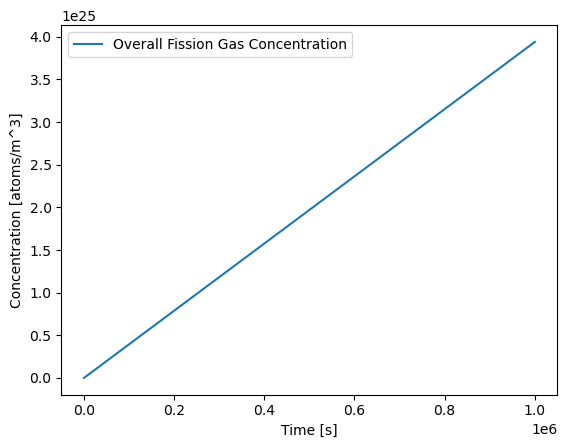

In [283]:
# convert the sympy expression to numerical function
P_lambda = sp.lambdify(t, P_final.rhs, 'numpy')

# plot the results
t_vals = np.linspace(0, 1e6, 100)
P_vals = P_lambda(t_vals)

plt.plot(t_vals, P_vals, label='Overall Fission Gas Concentration')
plt.xlabel('Time [s]')
plt.ylabel('Concentration [atoms/m^3]')
plt.legend()
plt.show()

In [284]:
display('Solution for G_M:')
## boundary conditions for GM 
boundary_outer = sp.Eq(symGM.subs(r, a/2), 0)   # Boundary at r = a/2 !!!!!!!!!!!!!!!!!
boundary_symmetry = sp.Eq(symGM.diff(r).subs(r, 0), 0)  # Symmetry Boundary Condition

# display the boundary conditions
display('Boundary Condition at grain surface:', boundary_outer)
display('Symmetry Boundary Condition:', boundary_symmetry)

# initial condition for GM
icGM = {symGM.subs(t, 0): 0}
display('Initial condition for GM:', icGM)

# waiting to solve the equation with initial conditions and boundary conditions, try to check steady state solution
display('We are just interested in the steady state solution for G_M:')
symGM_steady = sp.Function('G_M')(r)
eq_steady = sp.Eq(D_eff * (symGM_steady.diff(r, r) + (1/r) * symGM_steady.diff(r) ) + (f_yield * f_Rate), 0)
GM_steady = sp.dsolve(eq_steady, ics={symGM_steady.subs(r, a/2): 0, symGM_steady.diff(r).subs(r, 0): 0}) # !!!!!!!!!!!!!!!!

display(eq_steady)
display('The steady state solution for G_M is:', GM_steady)

GM_radial_steady = GM_steady.subs({
    D_eff: diffusivity_coeff,
    f_yield: FP_yield,
    f_Rate: avg_fission_rate,
})

display('By substituting known values:', GM_radial_steady)

'Solution for G_M:'

'Boundary Condition at grain surface:'

Eq(G_M(5.0e-6, t), 0)

'Symmetry Boundary Condition:'

Eq(Subs(Derivative(G_M(r, t), r), r, 0), 0)

'Initial condition for GM:'

{G_M(r, 0): 0}

'We are just interested in the steady state solution for G_M:'

Eq(D_eff*(Derivative(G_M(r), (r, 2)) + Derivative(G_M(r), r)/r) + f_yield*fission_rate, 0)

'The steady state solution for G_M is:'

Eq(G_M(r), -f_yield*fission_rate*r**2/(4*D_eff) + 6.25e-12*f_yield*fission_rate/D_eff)

'By substituting known values:'

Eq(G_M(r), 1.3660323014347e+23 - 5.46412920573881e+33*r**2)

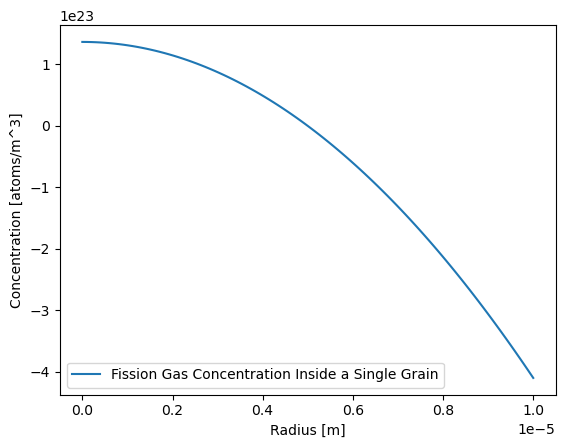

In [285]:
# plot the results of GM steady state solution radially
r_vals = np.linspace(0, a, 100)
GM_vals = [GM_radial_steady.rhs.subs(r, r_val) for r_val in r_vals]

plt.plot(r_vals, GM_vals, label='Fission Gas Concentration Inside a Single Grain')
plt.xlabel('Radius [m]')
plt.ylabel('Concentration [atoms/m^3]')
plt.legend()
plt.show()

In [286]:
### integrate the solution for GM in the radial direction
GM_final = 2 * GM_radial_steady.rhs.integrate((r, 0, a/2)) # found the steady state value for total gas inside the grain !!!!!!!!!!!!!!!!!

## compute the amount of gas released in plenum after 1 year

# production of fission gas in the fuel
time = 360 * 24 * 3600 # 1 year (of operation) in seconds
total_fission_gas = P_lambda(time) # total amount of fission gas produced

# total amount of fission gas inside the grains
n_grains_pellet = 1e5 # number of grains in a pellet
n_pellets_pin = round(850e-3/Geometrical_Data.fuel_pellet_height) # number of pellets in a pin
total_fission_gas_grains = GM_final * n_grains_pellet * n_pellets_pin

# total amount of fission gas released in the plenum
total_fission_gas_released = total_fission_gas - total_fission_gas_grains

display('The total fission gas produced in fuel cycle is:')
display(Math(r'P_{\text{total}} =' + f'{total_fission_gas:.2e}' + r'\text{ atoms/m}^3'))
display('The total fission gas remaining inside the grains is:')
display(Math(r'G_{\text{total}} =' + f'{total_fission_gas_grains:.2e}' + r'\text{ atoms/m}^3'))
display('The total fission gas released in the plenum is:')
display(Math(r'FG_{\text{released}} =' + f'{total_fission_gas_released:.2e}' + r'\text{ atoms/m}^3'))

'The total fission gas produced in fuel cycle is:'

<IPython.core.display.Math object>

'The total fission gas remaining inside the grains is:'

<IPython.core.display.Math object>

'The total fission gas released in the plenum is:'

<IPython.core.display.Math object>

#### To consider in the loop implementation

- Effect 1: FGR increases FGR due to k_gap reduction
let's compute the variation in k_gap, subsequent increase in T_fuel_out and so the further increase in fission gas production
this process is then stabilized by thermal expansion of the fuel and cladding --> closes gap 

- Effect 2: Swelling due to the gas trapped in the grains
let's impose a limit: we do not want the gap to be closed

Now plotting the pressure as a function of the plenum height

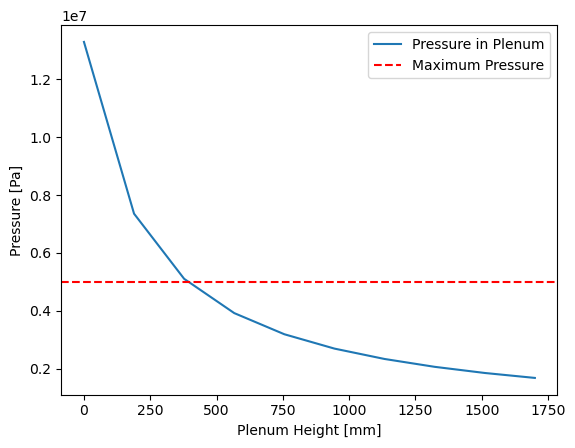

In [287]:
# vector of possible plenum heights
fuel_column_height = 850e-3 # m
h_vals_plenum = np.linspace(0, 2*fuel_column_height, 10)
# display(h_vals_plenum)

# corresponding volume to accomodate gases
V_plenum = (np.pi * r_cladding_gap**2 * h_vals_plenum) + (np.pi * (r_cladding_gap**2 - r_gap_fuel**2) * fuel_column_height)
# display(V_plenum)

# find initial quantity of He present in the plenum
initial_moles_he = vars.p_gas * V_plenum / (8.314 * (vars.T_gas + 273.15)) # moles
# display(initial_moles_he)

# find the additional moles of fission gases released in the plenum
V_pin = np.pi * (Geometrical_Data.fuel_outer_diameter/2)**2 * fuel_column_height # m^3
additional_moles_fg = (total_fission_gas_released * V_pin) / 6.022e23 # moles
# display(additional_moles_fg)

# find the total moles of gases in the plenum
total_moles_gas = initial_moles_he + additional_moles_fg # moles
# display(total_moles_gas)

# find the new pressure in the plenum
new_p_gas = total_moles_gas * 8.314 * (vars.T_gas + 273.15) / V_plenum # Pa
# display(new_p_gas)

# new pressure in plenum as a function of plenum height
plt.plot(h_vals_plenum * 1e3, new_p_gas, label='Pressure in Plenum')
plt.xlabel('Plenum Height [mm]')
plt.ylabel('Pressure [Pa]')
plt.legend()

# add a limit line for maximum allowed pressure at 5 MPa
plt.axhline(y=5e6, color='r', linestyle='--', label='Maximum Pressure')
plt.legend()
plt.show()

Testing the implementation of the function

In [288]:
h_plenum = 1  # m
He_percentage, Gas_Pressure = f.fission_gas_production(h_plenum, Fuel_Proprieties, ThermoHydraulics, Geometrical_Data, vars.T_map)
display(Math(r'\text{He Percentage} =' + f'{He_percentage:.2f}' + r'\%'))
display(Math(r'\text{Gas Pressure} =' + f'{Gas_Pressure*1e-6:.2f}' + r'\text{ MPa}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## He Production
Compute for 360 days of operation

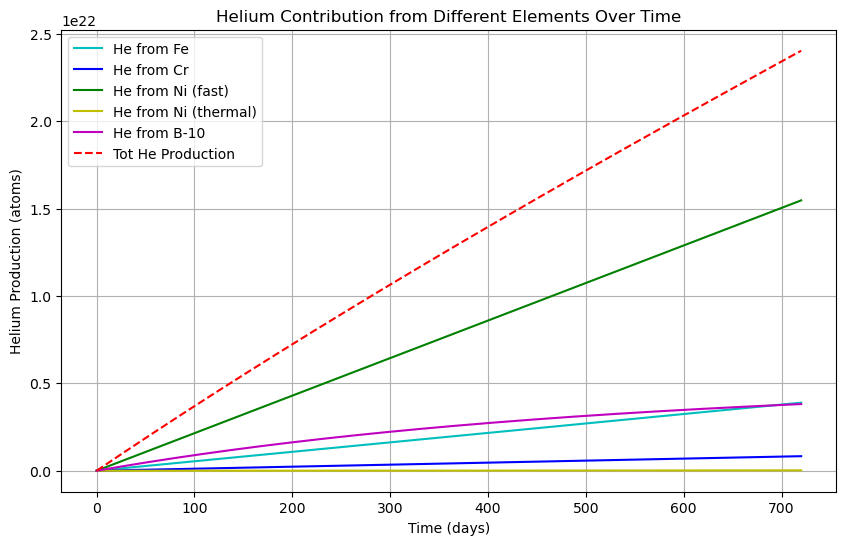

In [289]:
# Constants
avogadro_number = 6.022e23  # atoms/mol
density_steel = 7.9  # g/cm³ (approximate for stainless steel)
time_seconds = 2 * 360 * 24 * 3600  # 2 years in seconds

# Cladding composition (wt.%)
composition = {
    "Fe": 100 - (15.0 + 15.0 + 1.5 + 1.5 + 0.9 + 0.4 + 0.09),  # Balance is Iron
    "Cr": 15.0,
    "Ni": 15.0,
    "B": 0.006,  # Boron content in wt.% (ppm equivalent: 60 ppm)
}
molar_masses = {
    "Fe": 55.847,
    "Cr": 51.996,
    "Ni": 58.690,
    "B": 10.811,
}

# Cross-sections (cm²)
cross_sections = {
    "B10_thermal": 3837e-27,  # 10B(n,α) thermal
    "B10_fast": 623e-27,  # 10B(n,α) fast
    "Fe_fast": 0.23e-27,  # Fe(n,α)
    "Cr_fast": 0.20e-27,  # Cr(n,α)
    "Ni58_fast": 4.2e-27,  # 58Ni(n,α)
    "Ni59_thermal": 13.4e-27,  # 59Ni(n,γ)
}

# Isotopic abundance
isotopic_abundance = {"Ni58": 0.683, "B10": 0.198}

# Helper function for initial concentrations
def concentration(wt_percent, density, molar_mass):
    return (wt_percent * density * avogadro_number) / molar_mass

# Initial concentrations
N_Fe_0 = concentration(composition["Fe"], density_steel, molar_masses["Fe"])
N_Cr_0 = concentration(composition["Cr"], density_steel, molar_masses["Cr"])
N_Ni_0 = concentration(composition["Ni"], density_steel, molar_masses["Ni"])
N_58Ni_0 = isotopic_abundance["Ni58"] * N_Ni_0
N_59Ni_0 = 0  # Initial 59Ni is 0
N_extraNi_0 = N_Ni_0 * (1 - isotopic_abundance["Ni58"])
N_B10_0 = concentration(composition["B"], density_steel, molar_masses["B"]) * isotopic_abundance["B10"]
N_He_0 = 0  # Initial helium concentration

# Extended state vector
N_0_extended = np.array(
    [N_Fe_0, N_Cr_0, N_58Ni_0, N_59Ni_0, N_extraNi_0, N_B10_0, N_He_0, 0, 0, 0, 0, 0]
)

# Time parameters
t_0 = 0
t_f = time_seconds
t_span = (t_0, t_f)
t_eval = np.linspace(t_0, t_f, 1000)

# Neutron flux data
peak_flux = 6.1e15  # n/cm²/s at the peak node
peak_factors = np.array([0.572, 0.737, 0.868, 0.958, 1, 0.983, 0.912, 0.802, 0.658, 0.498])
flux_values = peak_flux * peak_factors  # Flux for each node

# Initialize total helium production across all nodes
total_helium_production = 0
num_nodes = len(flux_values)  # Number of nodes
# Initialize arrays to store cumulative helium contributions at each time step
average_helium_contributions = np.zeros_like(t_eval)

He_contrib_Fe = np.zeros_like(t_eval)
He_contrib_Cr = np.zeros_like(t_eval)
He_contrib_Ni_fast = np.zeros_like(t_eval)
He_contrib_Ni_therm = np.zeros_like(t_eval)
He_contrib_B10 = np.zeros_like(t_eval)

from scipy.integrate import solve_ivp
for fast_flux in flux_values:
    # Bateman system of equations with helium contributions
    
    def Bateman_sys_with_He_contrib(t, state):
        N_Fe, N_Cr, N_58Ni, N_59Ni, N_extraNi, N_B10, N_He, He_Fe, He_Cr, He_Ni_fast, He_Ni_therm, He_B10 = state
        thermal_flux = fast_flux # HYPOTHESIS
        # Reaction rates
        dN_58Ni_dt = -cross_sections["Ni58_fast"] * fast_flux * N_58Ni
        dN_59Ni_dt = (
            cross_sections["Ni58_fast"] * fast_flux * N_58Ni
            - cross_sections["Ni59_thermal"] * thermal_flux * N_59Ni
        )
        dN_extraNi_dt = -cross_sections["Ni58_fast"] * fast_flux * N_extraNi
        dN_Fe_dt = -cross_sections["Fe_fast"] * fast_flux * N_Fe
        dN_Cr_dt = -cross_sections["Cr_fast"] * fast_flux * N_Cr
        dN_B10_dt = -(
            cross_sections["B10_thermal"] * thermal_flux
            + cross_sections["B10_fast"] * fast_flux
        ) * N_B10
        
        # Helium production contributions
        dHe_Fe = cross_sections["Fe_fast"] * fast_flux * N_Fe
        dHe_Cr = cross_sections["Cr_fast"] * fast_flux * N_Cr
        dHe_Ni_fast = cross_sections["Ni58_fast"] * fast_flux * (N_58Ni + N_59Ni + N_extraNi)
        dHe_Ni_therm = cross_sections["Ni59_thermal"] * thermal_flux * N_59Ni
        dHe_B10 = (
            cross_sections["B10_thermal"] * thermal_flux * N_B10
            + cross_sections["B10_fast"] * fast_flux * N_B10
        )
        dN_He_dt = dHe_Fe + dHe_Cr + dHe_Ni_fast + dHe_Ni_therm + dHe_B10
        
        # Combine rates
        return [
            dN_Fe_dt,
            dN_Cr_dt,
            dN_58Ni_dt,
            dN_59Ni_dt,
            dN_extraNi_dt,
            dN_B10_dt,
            dN_He_dt,
            dHe_Fe,
            dHe_Cr,
            dHe_Ni_fast,
            dHe_Ni_therm,
            dHe_B10,
        ]

    # Solve the system
    
    sol_extended = solve_ivp(
        Bateman_sys_with_He_contrib,
        t_span,
        N_0_extended,
        t_eval=t_eval,
        method="RK45",
    )

    # Labels and colors for the plots
    labels = ["[Fe]", "[Cr]", "[Ni-58]", "[Ni-59]", "[Ni-extra]", "[B-10]", "[He]"]
    colors = ["c", "b", "g", "y", "k", "m", "r"]

    # Extract helium contributions
    He_contrib_Fe += sol_extended.y[7]
    He_contrib_Cr += sol_extended.y[8]
    He_contrib_Ni_fast += sol_extended.y[9]
    He_contrib_Ni_therm += sol_extended.y[10]
    He_contrib_B10 += sol_extended.y[11]
    
# Calculate total helium contribution for this node
total_helium_production = (
    He_contrib_Fe
    + He_contrib_Cr
    + He_contrib_Ni_fast
    + He_contrib_Ni_therm
    + He_contrib_B10
)

# Calculate the average helium contributions over all nodes
final_He = total_helium_production[-1]
    
# Plot the average helium contribution over time
plt.figure(figsize=(10, 6))
plt.plot(sol_extended.t / (24 * 3600), He_contrib_Fe, label="He from Fe", color="c")
plt.plot(sol_extended.t / (24 * 3600), He_contrib_Cr, label="He from Cr", color="b")
plt.plot(sol_extended.t / (24 * 3600), He_contrib_Ni_fast, label="He from Ni (fast)", color="g")
plt.plot(sol_extended.t / (24 * 3600), He_contrib_Ni_therm, label="He from Ni (thermal)", color="y")
plt.plot(sol_extended.t / (24 * 3600), He_contrib_B10, label="He from B-10", color="m")
plt.plot(sol_extended.t / (24 * 3600), total_helium_production, label="Tot He Production", color="r", linestyle="--")
plt.title("Helium Contribution from Different Elements Over Time")
plt.xlabel("Time (days)")
plt.ylabel("Helium Production (atoms)")
plt.legend(loc="best")
plt.grid()
plt.show()

In [290]:
# If we assume all the He is kept inside the cladding (very cnservative consideration)
Elements=["Cr", "Ni", "Mo", "Mn", "Si", "Ti", "C", "B [ppm]"],
Qualities=[15, 15, 1.5, 1.5, 0.9, 0.4, 0.09, 60],
Molar_mass = (15 * 51.996 + 15 * 58.693 + 1.5 * 95.94 + 1.5 * 54.938 + 0.9 * 28.085 + 0.4 * 47.867 + 0.09 * 12.011)/100 # g/mol
density_steel = 7.9 # g/cm³
volume = np.pi * (r_cladding**2 - r_cladding_gap**2) * fuel_column_height # m³
volume = volume[0] * 1e6 # cm³
atoms_cladding = volume * density_steel * Molar_mass * avogadro_number

# Calculate average helium concentration in ppm
# Since we assume they all stay in the same medium we don't need to evaluate concentrations and we divide the number of atoms
average_helium_concentration_ppm = (final_He / atoms_cladding) * 1e6

# Print the helium production contributions and final average concentration
print(f"Helium concentration: {average_helium_concentration_ppm:.2f} ppm")

# Print the final average value
print(f"Total helium production: {final_He:.2e} atoms")

Helium concentration: 151.87 ppm
Total helium production: 2.40e+22 atoms


## Pu Redistribution

2.71


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

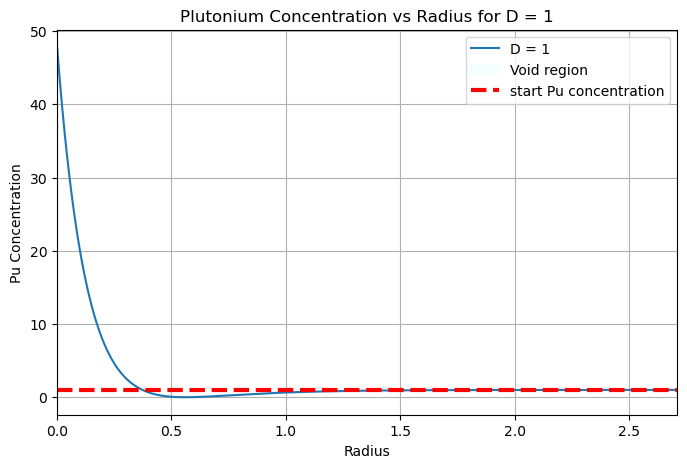

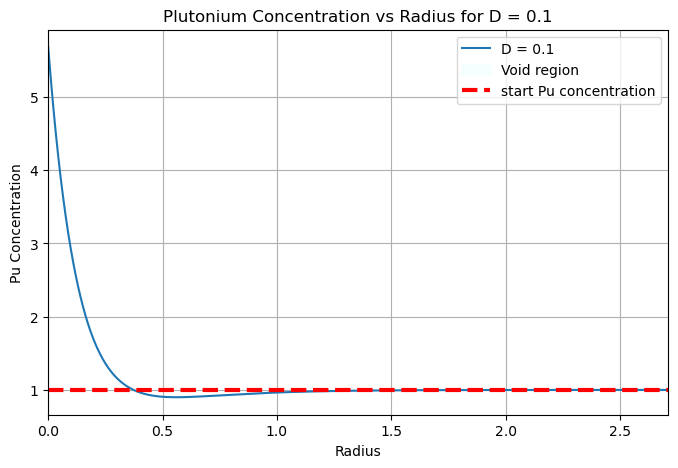

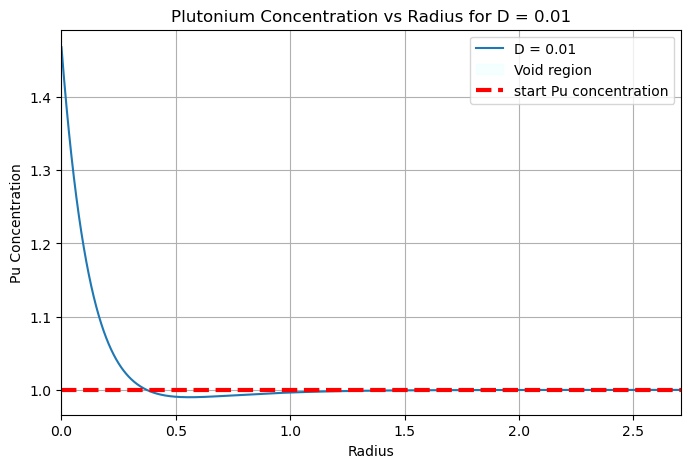

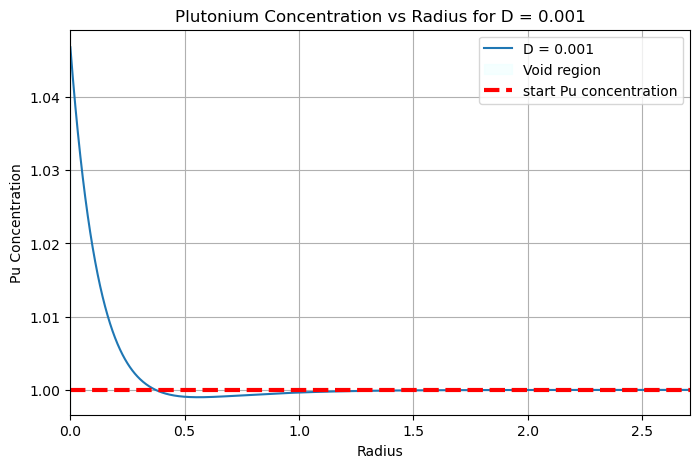

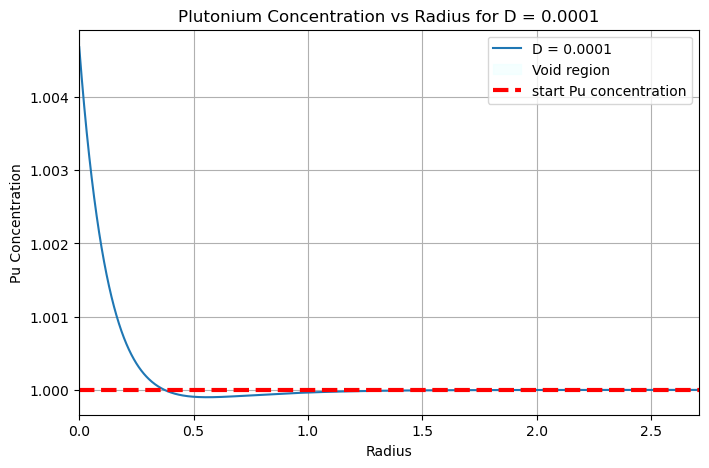

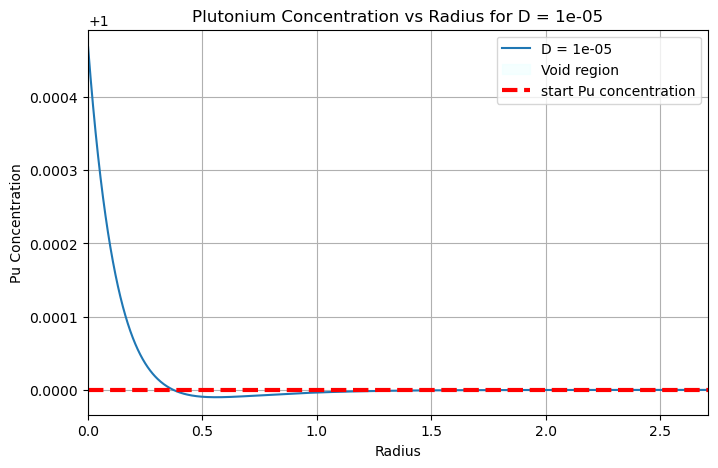

In [291]:
#function to define the value of [wt%] in a precise radius
def get_plutonium_at_radius(radius_value):
  for i, D in enumerate(D_values):
    if D_values[i] == 0.1:
      Pu_r_value = Pu_r(radius_value,D)
  return Pu_r_value

#coef definition #using the concept of conservation of plutonium
heights_of_slice_centre = [42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5] # mm
D_values = [1,0.1,0.01,0.001,0.0001,0.00001] #exponential fit
Pu_start = 0.29 #reffered to the initial concentration (power) of plutonium
R = 2.71 #mm                                #(fuel_outer_diameter/2)*10**3
print(R)
R_void = 0.00038319
display(Math(r'R_{fuel} =' + f'{R:.6f}' + r'\text{mm}'))
def alfa_function(R_gas,E,T):
  alfa = E*10**3/(R_gas*T)
  return alfa
R_gas = 8.314 #J/molK
E = 350 #from paper(i have the name) it is written that the value is in the range of 350 and 450 kj/mol
T_ref = f.get_temperature_at_point(heights_of_slice_centre[4],0,vars.T_map) #starting the evaluation with the worst case
#alfa_value = alfa_function(R_gas,E,T_ref)
alfa_value = 10
display(Math(r'alfa =' + f'{alfa_value:.6f}' + r'\text{}'))
display(Math(r'T_{ref} =' + f'{T_ref:.6f}' + r'\text{ K}'))
radius_vector = np.linspace(R_void,R,1000)
r_star = R*0.207  #the star radius, which is the minimum of Pu concentration, is taken from the handouts

#Pu_r = lambda r,D: Pu_start + Pu_start*(D*(np.exp(-2*alfa_value*((r-r_star)/R)) + 2*np.exp(-alfa_value*((r-r_star)/R))))
#Pu_r = lambda r, D: 1 - D * (np.exp(-2 * alfa_value * ((r - r_star) / R)) - 2 * np.exp(-alfa_value * ((r - r_star) / R))) #ratio between the Pu concentration radius-dependent and the initial value of Pu concentration
Pu_r = lambda r,D: 1 + D * (+np.exp(-2 * alfa_value * (r - r_star) / R) - 2 * np.exp(-(alfa_value) * (r - r_star) / R))
#Pu_r = lambda r,D: 1 + D*(np.exp(-((r-r_star)**2)/R**2) - np.exp(-alfa_value*(r/R)))

# Generate and plot graphs for each value of D
for i, D in enumerate(D_values):
    Pu_concentration = Pu_r(radius_vector, D)
    plt.figure(figsize=(8, 5))
    plt.plot(radius_vector, Pu_concentration, label=f'D = {D}')
    plt.axvspan(0,R_void, color='lightcyan', alpha=0.3, label='Void region')
    plt.axhline(y=1, color='red', linestyle='--',linewidth = '3', label='start Pu concentration')
    plt.xlim(0, R)  # 0 as the lower bound, None for no upper bound

    # plotting of the graph
    plt.xlabel('Radius')
    plt.ylabel('Pu Concentration')
    plt.title(f'Plutonium Concentration vs Radius for D = {D}')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

# Stress Analysis - Pipe Equation

In [292]:
r = sp.symbols('r')
sigma_r = sp.symbols('sigma_r', cls=sp.Function)
alfa = sp.symbols('alfa', real = True, nonnegative = True)
E = sp.symbols('E', real = True, nonnegative = True)
ni = sp.symbols('ni')
T = sp.symbols('T', cls=sp.Function)
Ro =  3.31*10**-3
Ri = 3.22*10**-3
r_vector = np.linspace(Ri,Ro,50)
To = f.get_temperature_at_point(0.425, Ro, vars.T_map) - 273
Ti = f.get_temperature_at_point(0.425, Ri, vars.T_map) - 273
print(f'the value of temperature at inner cladding is {Ti}')

the value of temperature at inner cladding is 574.653846680415


In [293]:
E_value1 = Cladding_Proprieties.Youngs_Modulus(To)
E_value2 = Cladding_Proprieties.Youngs_Modulus(Ti)
ni_value1 = Cladding_Proprieties.Poissons_Ratio(To)
ni_value2 = Cladding_Proprieties.Poissons_Ratio(Ti)

E_value_real = (E_value1 + E_value2)/2
ni_value_real = (ni_value1 + ni_value2)/2

#function definition, using superposition problem
func1 = sp.Eq(
    (r**3*sigma_r(r).diff(r)).diff(r),0
)

func2 = sp.Eq(
    ((alfa*E*r**2)/(1-ni))*T(r).diff(r),0
)
display(func1)
display(func2)

Eq(r**3*Derivative(sigma_r(r), (r, 2)) + 3*r**2*Derivative(sigma_r(r), r), 0)

Eq(E*alfa*r**2*Derivative(T(r), r)/(1 - ni), 0)

In [294]:
#C1,C2,C3,C4 = sp.symbols("C1 C2 C3 C4")
solution1 = sp.dsolve(func1,ics={sigma_r(r).subs(r, Ro): -0.2, sigma_r(r).subs(r, Ri): -2.5}) #pressure at the two extreme of the cladding
#solution2 = sp.dsolve(func2,ics={T(r).subs(r, Ro): To}) #temperature condition at two cladding extreme
#ics={T(r).subs(r, Ro): To, T(r).subs(r, Ri): Ti}

#Print of the solutions
print("sigma_r(r):")
display(solution1)

sigma_r(r):


Eq(sigma_r(r), 40.3773694061598 - 0.000444569716950827/r**2)

In [295]:
#Rewrite it in for copy paste into loop
# DATA FROM THE LOOP
pressure_in = -2.5
pressure_out = -0.2
radius_in = Ri
radius_out = Ro
# EXPRESSION
Costant_1 = 2 * (pressure_out - pressure_in) * radius_in**2 * radius_out**2 / (radius_out**2 - radius_in**2)
Costant_2 = pressure_in + Costant_1 / (2 * radius_in**2)
sigma_r_lambda = -Costant_1/(2*r**2) + Costant_2
display(sigma_r_lambda)
sigma_r_lambda = lambda radius: -Costant_1/(2*radius**2) + Costant_2

40.3773694061596 - 0.000444569716950826/r**2

In [296]:
#Symbolic solution for sigma_theta
sigma_r_solution = solution1.rhs        #+ solution2.rhs
print("real solution of sigma_r:")
display(sigma_r_solution)

real solution of sigma_r:


40.3773694061598 - 0.000444569716950827/r**2

In [297]:
sigma_theta = sp.symbols('sigma_theta', cls=sp.Function)
#func3 = sp.Eq(sigma_theta(r), sigma_r_solution(r) + r*sigma_r_solution(r).diff(r))
func3 = sp.Eq(sigma_theta(r), sigma_r_solution + r * sp.diff(sigma_r_solution, r)) #l'errore sta qui nel calcolo della derivata di sigma_r
sigma_theta_eq = func3.rhs
print("Solution of sigma_theta:")
display(func3)

Solution of sigma_theta:


Eq(sigma_theta(r), 40.3773694061598 + 0.000444569716950827/r**2)

In [298]:
#Symbolic solution for sigma_z
sigma_z = sp.symbols('sigma_z', cls=sp.Function)
func4 = sp.Eq(sigma_z(r), sigma_r_solution + sigma_theta_eq)
sigma_z_eq = func4.rhs

print("Solution of sigma_z:")
display(func4)

Solution of sigma_z:


Eq(sigma_z(r), 80.7547388123195)

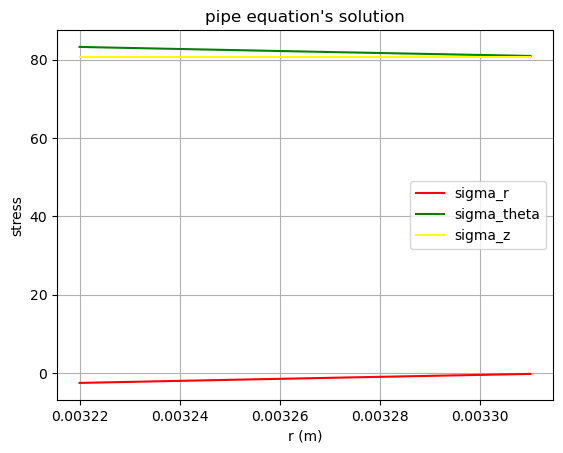

In [299]:
#numerical solution for the plot
numerical_sigma_r = sp.lambdify(r, sigma_r_solution, 'numpy')
#numerical_sigma_theta = sp.lambdify(r, sigma_theta_eq, 'numpy')
#numerical_sigma_z = sp.lambdify(r,sigma_z_eq, 'numpy')

##Starting from sigma_r's equation, we are able to find in numerical way sigma_theta and sigma_z  
numerical_sigma_theta2 = lambda r: 40.3773694061598 - (0.000444569716950827)/(r**2) + (2*0.000444569716950827)/(r**2)
numerical_sigma_z2 = lambda r: 40.3773694061596 - (0.000444569716950827)/(r**2) + 40.3773694061596 - (0.000444569716950827)/(r**2) + (2*0.000444569716950827)/(r**2)

#Function to plot
sigma_r_plot = numerical_sigma_r(r_vector)
#sigma_theta_plot = numerical_sigma_theta(r_vector)
#sigma_z_plot = numerical_sigma_z(r_vector)
sigma_theta_plot2 = numerical_sigma_theta2(r_vector)
sigma_z_plot2 = numerical_sigma_z2(r_vector)

#plot of the graph
plt.plot(r_vector,sigma_r_plot, color='red', label = 'sigma_r'), plt.plot(r_vector, sigma_theta_plot2, color='green', label='sigma_theta'), plt.plot(r_vector, sigma_z_plot2, color='yellow',label = 'sigma_z')
plt.title("pipe equation's solution")
plt.xlabel('r (m)')
plt.ylabel('stress')
plt.grid(True)
plt.legend(loc='best')
plt.show()

We can see that the variation is minimum between inside and outside. In the loop we are going to take the mid radius as a reference

In [300]:
#fuel valore da calcolare media aritmetica da la min e la max
def E_f(T, p):  #temperatura hot del fuel(farei una media)
  E = (22.43*10**4 - 31.19*T)*(1 - 2.6*p)
  return E

#cladding stessa temperatura circa
def clad_strain_function(T):  #temperatura in hot, cladding(farei una media dei valori)
  strain = -3.101*10**-4 + 1.545*(10**-5)*T + 2.75*(10**-9)*T**2
  return strain

r_hot_in, r_init_in, T_hot_in = f.cold_to_hot_clad(Cladding_Proprieties, Geometrical_Data, vars, h_vals, flag = 'inner')
r_hot_out, r_init_out, T_hot_out = f.cold_to_hot_clad(Cladding_Proprieties, Geometrical_Data, vars, h_vals, flag = 'outer')

In [301]:
T_clad = np.mean(T_hot_in)
display(Math(r'T_{clad} =' + f'{T_clad:.6f}' + r'\text{K}'))

<IPython.core.display.Math object>

In [302]:
R_new, R_start, T_hot = f.cold_to_hot_fuel(Fuel_Proprieties,Geometrical_Data,vars,h_vals) #fuel R after thermal expansion
R_new_value = np.mean(R_new)
T_fo = f.get_temperature_at_point(0.425, R_new_value ,vars.T_map) #da fare la hot geometry
display(Math(r'T_{fo} =' + f'{T_fo:.6f}' + r'\text{K}'))

<IPython.core.display.Math object>

In [303]:
T_fi = f.get_temperature_at_point(0.425,R_void , vars.T_map) #da fare la hot geometry
display(Math(r'T_{fi} =' + f'{T_fi:.6f}' + r'\text{K}'))

<IPython.core.display.Math object>

In [304]:

T_mean = (T_fo+T_fi)/2

#quello che manca è tenere in considerazione thermal stress

ni_fuel = 0.32
E_value = E_f(T_mean, 0.02)
clad_strain_value = clad_strain_function(T_clad)
bu = 64.134 #GWd/tons
strain_fuel = 0.07*bu/100

P_sw_fuel =  E_value*(strain_fuel - clad_strain_value)/(1-ni_fuel)  #questa parte non so se ha senso, è per tenere in condiderazione quello swelling fuel strain che dà nel testo
display(Math(r'Psw_{clad} =' + f'{P_sw_fuel:.6f}' + r'\text{MPa}'))

<IPython.core.display.Math object>

In [305]:
#find the max value of principal stress to make a test
#using tresca test

mean_stress = [] #sigma_r_mean, sigma_theta_mean, sigma_z_mean

mean_sigma_r = (-0.2-2.5)/2
mean_stress.append(mean_sigma_r)

mean_sigma_theta = (numerical_sigma_theta2(Ri) + numerical_sigma_theta2(Ro))/2
mean_stress.append(mean_sigma_theta)

mean_sigma_z = (numerical_sigma_z2(Ri) + numerical_sigma_z2(Ro))/2
mean_stress.append(mean_sigma_z)

print(mean_stress)

[-1.35, 82.10473881231957, 80.7547388123192]


In [306]:
def max_abs_difference_between_pairs(vector):  #Find the maximum of the difference module between each pair of values of the vector

    max_difference = 0
    pair = (None, None) #the matching values pair

    # for cycle to find the maximum
    for i in range(len(vector)):
        for j in range(i + 1, len(vector)):
            diff = abs(vector[i] - vector[j])  # Modulo della differenza
            if diff > max_difference:
                max_difference = diff #the maximum value of the module of the difference between pairs
                pair = (vector[i], vector[j])

    return max_difference, pair

max_sigma,p = max_abs_difference_between_pairs(mean_stress)

display(Math(r'max_{sigma} =' + f'{max_sigma:.6f}' + r'\text{Mpa}'))

<IPython.core.display.Math object>

In [307]:
#yield stress
sigma_Y = 555.5 - 0.25*Ti
display(Math(r'sigma_{Y} =' + f'{sigma_Y:.6f}' + r'\text{Mpa}'))

<IPython.core.display.Math object>

In [308]:
#ultimate tensile stress
sigma_uts = 700 - 0.3125*Ti
display(Math(r'sigma_{UTS} =' + f'{sigma_uts:.6f}' + r'\text{Mpa}'))

<IPython.core.display.Math object>

In [309]:
##verifica##
if max_sigma < 2/3*sigma_Y and max_sigma < 1/3*sigma_uts:
  print('no problem :) ')
else:
  print('oh no, problems :(')


no problem :) 


## Thermal Creep
So basically even without being in the plastic domain we might encounter rupture of the cladding due to *creep* (See Beghi)

Max Stress: 100.51836268697366 MPa
Rupture Time: 4.4076163610719545 years


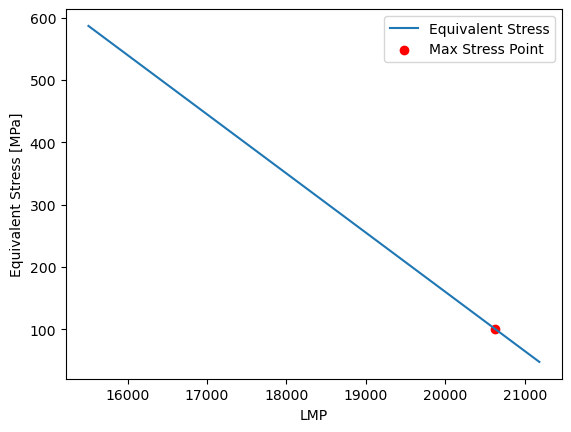

In [310]:
# Get the rupture strain of the cladding

rupture_strain, temperature_1 = f.rupture_strain(vars.T_map, cladding_inner_diam=3.225e-3)
rupture_strain = [r*1e-2 for r in rupture_strain]

# Get the LMP
useful_life = 365*24  # years
mat_const = 17.125 # material constant

LMP_param, temp_2 = f.LMP(vars.T_map, useful_life, mat_const, rupture_strain,cladding_inner_diam=3.225e-3)

# Equivalent stress
equivalent_stress = []

for h_i, i in enumerate(LMP_param):

    equivalent_stress.append(2060 -0.095*LMP_param[h_i])


max_temp = 950 # K

max_stress, max_LMP, rup_strain = f.get_stress_from_graph(max_temp, useful_life)

log10_rupture_time = ((max_LMP / max_temp ) -17.125)
rupture_time = 10**log10_rupture_time

print(f'Max Stress: {max_stress} MPa')
print(f'Rupture Time: {rupture_time/(365*24)} years')

# Plot the equivalent stress profile over the LMP

plt.plot(LMP_param, equivalent_stress, label='Equivalent Stress')
plt.xlabel('LMP')
plt.ylabel('Equivalent Stress [MPa]')
plt.scatter(max_LMP, max_stress, color='red', label='Max Stress Point')
plt.legend() 
plt.show()


In [311]:
# Let's use the previously computed stress as the input for the creep rupture model
stress = max_stress # computed with the Tresca criterion

LM_parameter = (2060 - stress)/0.095 # computed Larson-Miller Parameter with the equivalent stress

time_to_rupture = 10**((LM_parameter / max_temp) - 17.125) # hours
time_to_rupture = time_to_rupture / (365*24) # years

display(Math(r'\text{Time to Rupture: }' + f'{time_to_rupture:.2f}' + r'\text{ years}'))

<IPython.core.display.Math object>